## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data I need

In [3]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/stan_demontmarin/.fastai/data/planet')

In [4]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

#### Unpacking the data

In [5]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Time for some MULTICLASSIFICATION model  bitches !

Contrary to the last exercices we did, each picture can now have multiple labels attached to it.

The CSV file containing the labels is train_v2.csv

In [6]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [9]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

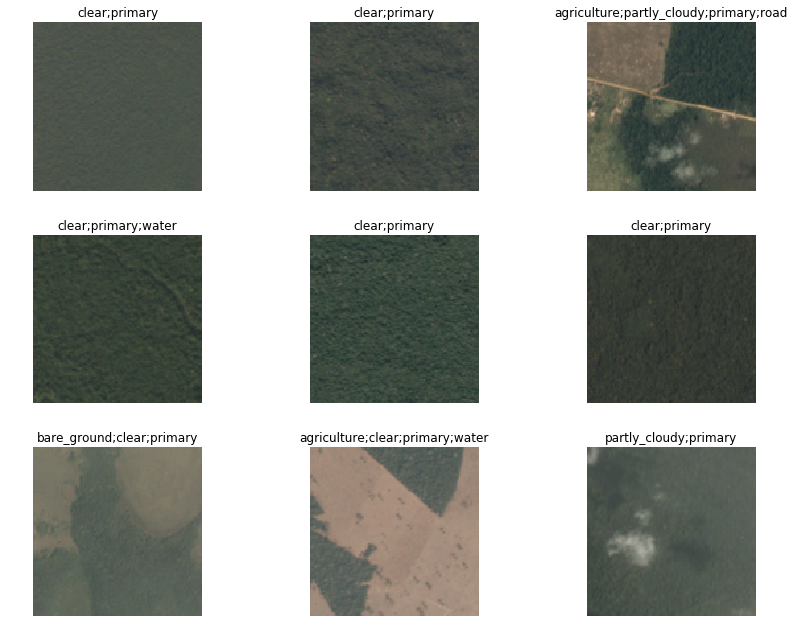

In [10]:
data.show_batch(rows=3, figsize=(12,9))

To create a Learner we use the same function as in lesson 1. 

Our base architecture is resnet34 again, 

but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. 

In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. 

accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. 

In [11]:
arch = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh = 0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


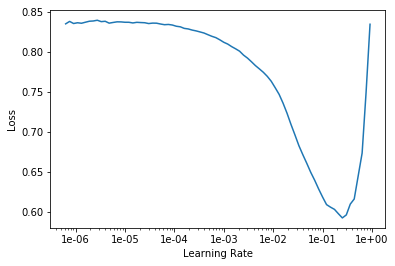

In [14]:
learn.recorder.plot()

Then we can fit the head of our network

In [15]:
lr = 1e-02

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125225,0.112085,0.949809,0.900911,00:53
1,0.106674,0.100198,0.955354,0.912903,00:52
2,0.100794,0.091461,0.956262,0.920120,00:52
3,0.095925,0.088241,0.956872,0.922834,00:52
4,0.092906,0.086758,0.955397,0.924152,00:52


In [17]:
learn.save('stage-1-rn50')

### fine tuning the whole model

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


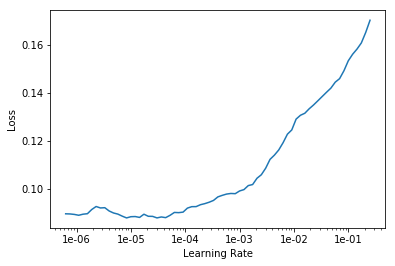

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-05, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097444,0.091630,0.948966,0.919296,01:09
1,0.095981,0.089383,0.956247,0.923840,01:09
2,0.092433,0.085219,0.958871,0.927231,01:09
3,0.086536,0.082623,0.957774,0.929145,01:09
4,0.080352,0.082026,0.958369,0.928740,01:09


In [21]:
learn.save('stage-2-rn50')

## let's try training our model with a size of 256 instead of 128

In [22]:
data = (src.transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [23]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


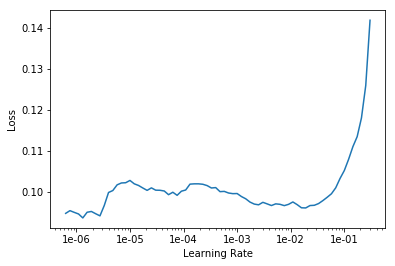

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr=1e-2/2

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087957,0.084535,0.957868,0.926808,02:48
1,0.088667,0.083843,0.955434,0.925943,02:46
2,0.085449,0.082895,0.958471,0.929368,02:46
3,0.083323,0.081430,0.958544,0.930261,02:46
4,0.079507,0.081163,0.959997,0.930699,02:46


In [27]:
learn.save('stage-1-256-rn50')

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [29]:
learn.unfreeze()

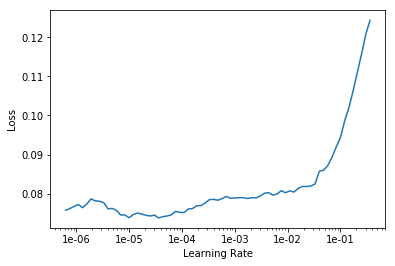

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084239,0.082544,0.956618,0.928569,03:41
1,0.086427,0.085129,0.959081,0.928449,03:40
2,0.082024,0.081997,0.957941,0.928623,03:40
3,0.077745,0.080709,0.959583,0.930234,03:40
4,0.072677,0.080395,0.959321,0.931729,03:40


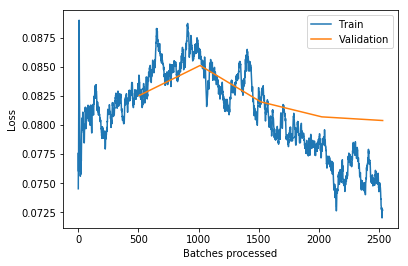

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.save('stage-2-256-rn50')

In [34]:
learn.export()

## Testing et commiting to kaggle competition

In [45]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 98%|████████████████████████████████████████▎| 593M/603M [00:03<00:00, 211MB/s]
100%|█████████████████████████████████████████| 603M/603M [00:03<00:00, 198MB/s]
 94%|██████████████████████████████████████▌  | 286M/304M [00:02<00:00, 168MB/s]
100%|█████████████████████████████████████████| 304M/304M [00:02<00:00, 143MB/s]


In [46]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [47]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [48]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [49]:
labelled_preds[:5]

['clear primary',
 'clear primary water',
 'clear primary road',
 'haze primary',
 'clear primary']

In [50]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [51]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [52]:
df.to_csv(path/'submission.csv', index=False)

In [53]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|███████████████████████████████████████| 2.20M/2.20M [00:05<00:00, 415kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space